In [1]:
import numpy as np
import pandas as pd
from aeon.transformations.collection.convolution_based import Rocket
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from aeon.datasets import load_classification

from windowshap import MyWindowSHAP
from sklearn.model_selection import train_test_split

from mylimesegment import explain_with_LIMESegment, explain_with_LEFTIST


/home/thachln/miniconda3/envs/captum/lib/python3.11/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


In [2]:
def plot_explanation(exps, titles = []):
    fig,axs = plt.subplots(len(exps),1,figsize=(30,4*len(exps)))
    for i,exp in enumerate(exps):
        if len(exp.shape) == 1:
            axs[i].plot(exp)
        elif len(exp.shape) == 2:
            axs[i].plot(exp[0,:])
        elif len(exp.shape) == 3:
            axs[i].plot(exp[0,0,:])
        if len(titles) > i:
            axs[i].set_title(titles[i])
    plt.show()

In [3]:
def add_stationary_ramps(X, ramp_length = 10, ramp_start = 0, ramp_value = 1):
    X_copy = X.copy()
    X_copy[...,ramp_start:(ramp_start + ramp_length)] += ramp_value
    return X_copy

def add_location_random_ramps(X, ramp_length = 10, ramp_starts = [], ramp_value = 1):
    X_copy = X.copy()
    for i in range(len(X_copy)):
        rs = np.random.choice(ramp_starts)    
        X_copy[i,:,rs:(rs + ramp_length)] += ramp_value
    return X_copy
def create_toy_dataset():
    series_length = 100
    num_samples = 60
    num_channels = 1
    base_X = np.random.normal(0,1,(num_samples,num_channels,series_length))
    class_split = num_samples // 2
    ramped_X = np.zeros((num_samples,num_channels,series_length))
    #ramped_X[:class_split,...] = add_stationary_ramps(base_X[:class_split,...], ramp_length = 10, ramp_start = 30, ramp_value = 10)
    #ramped_X[class_split:,...] = add_stationary_ramps(base_X[class_split:,...], ramp_length = 10, ramp_start = 30, ramp_value = -10)
    ramped_X[:class_split,...] = add_location_random_ramps(base_X[:class_split,...], ramp_length = 10, ramp_starts = [30,60], ramp_value = 10)
    ramped_X[class_split:,...] = add_location_random_ramps(base_X[class_split:,...], ramp_length = 10, ramp_starts = [30,60], ramp_value = -10)
    y = np.zeros(num_samples)
    y[class_split:] = 1
    return ramped_X,y

In [4]:
X_toy,y_toy = create_toy_dataset()  
X_train, X_test, y_train, y_test = train_test_split(X_toy, y_toy, test_size=0.33, stratify=y_toy,random_state=42)

In [5]:
ds = 'GunPoint'
X_train, y_train = load_classification(ds, split='train')
X_test, y_test = load_classification(ds, split='test')



In [6]:
clf = make_pipeline(
              Rocket(random_state=142),
              LogisticRegression(),
                
          ).fit(X_train, y_train)

In [7]:
stationary_exp = MyWindowSHAP(clf.predict_proba, test_data = X_test[[0]], background_data = X_train, window_len = 20).shap_values()

In [8]:
sliding_exp = MyWindowSHAP(clf.predict_proba, test_data = X_test[[0]], background_data = X_train, window_len = 10, stride = 5, method = 'sliding').shap_values()

In [9]:
dynamic_exp = MyWindowSHAP(clf.predict_proba, test_data = X_test[[0]], background_data = X_train, method = 'dynamic').shap_values()

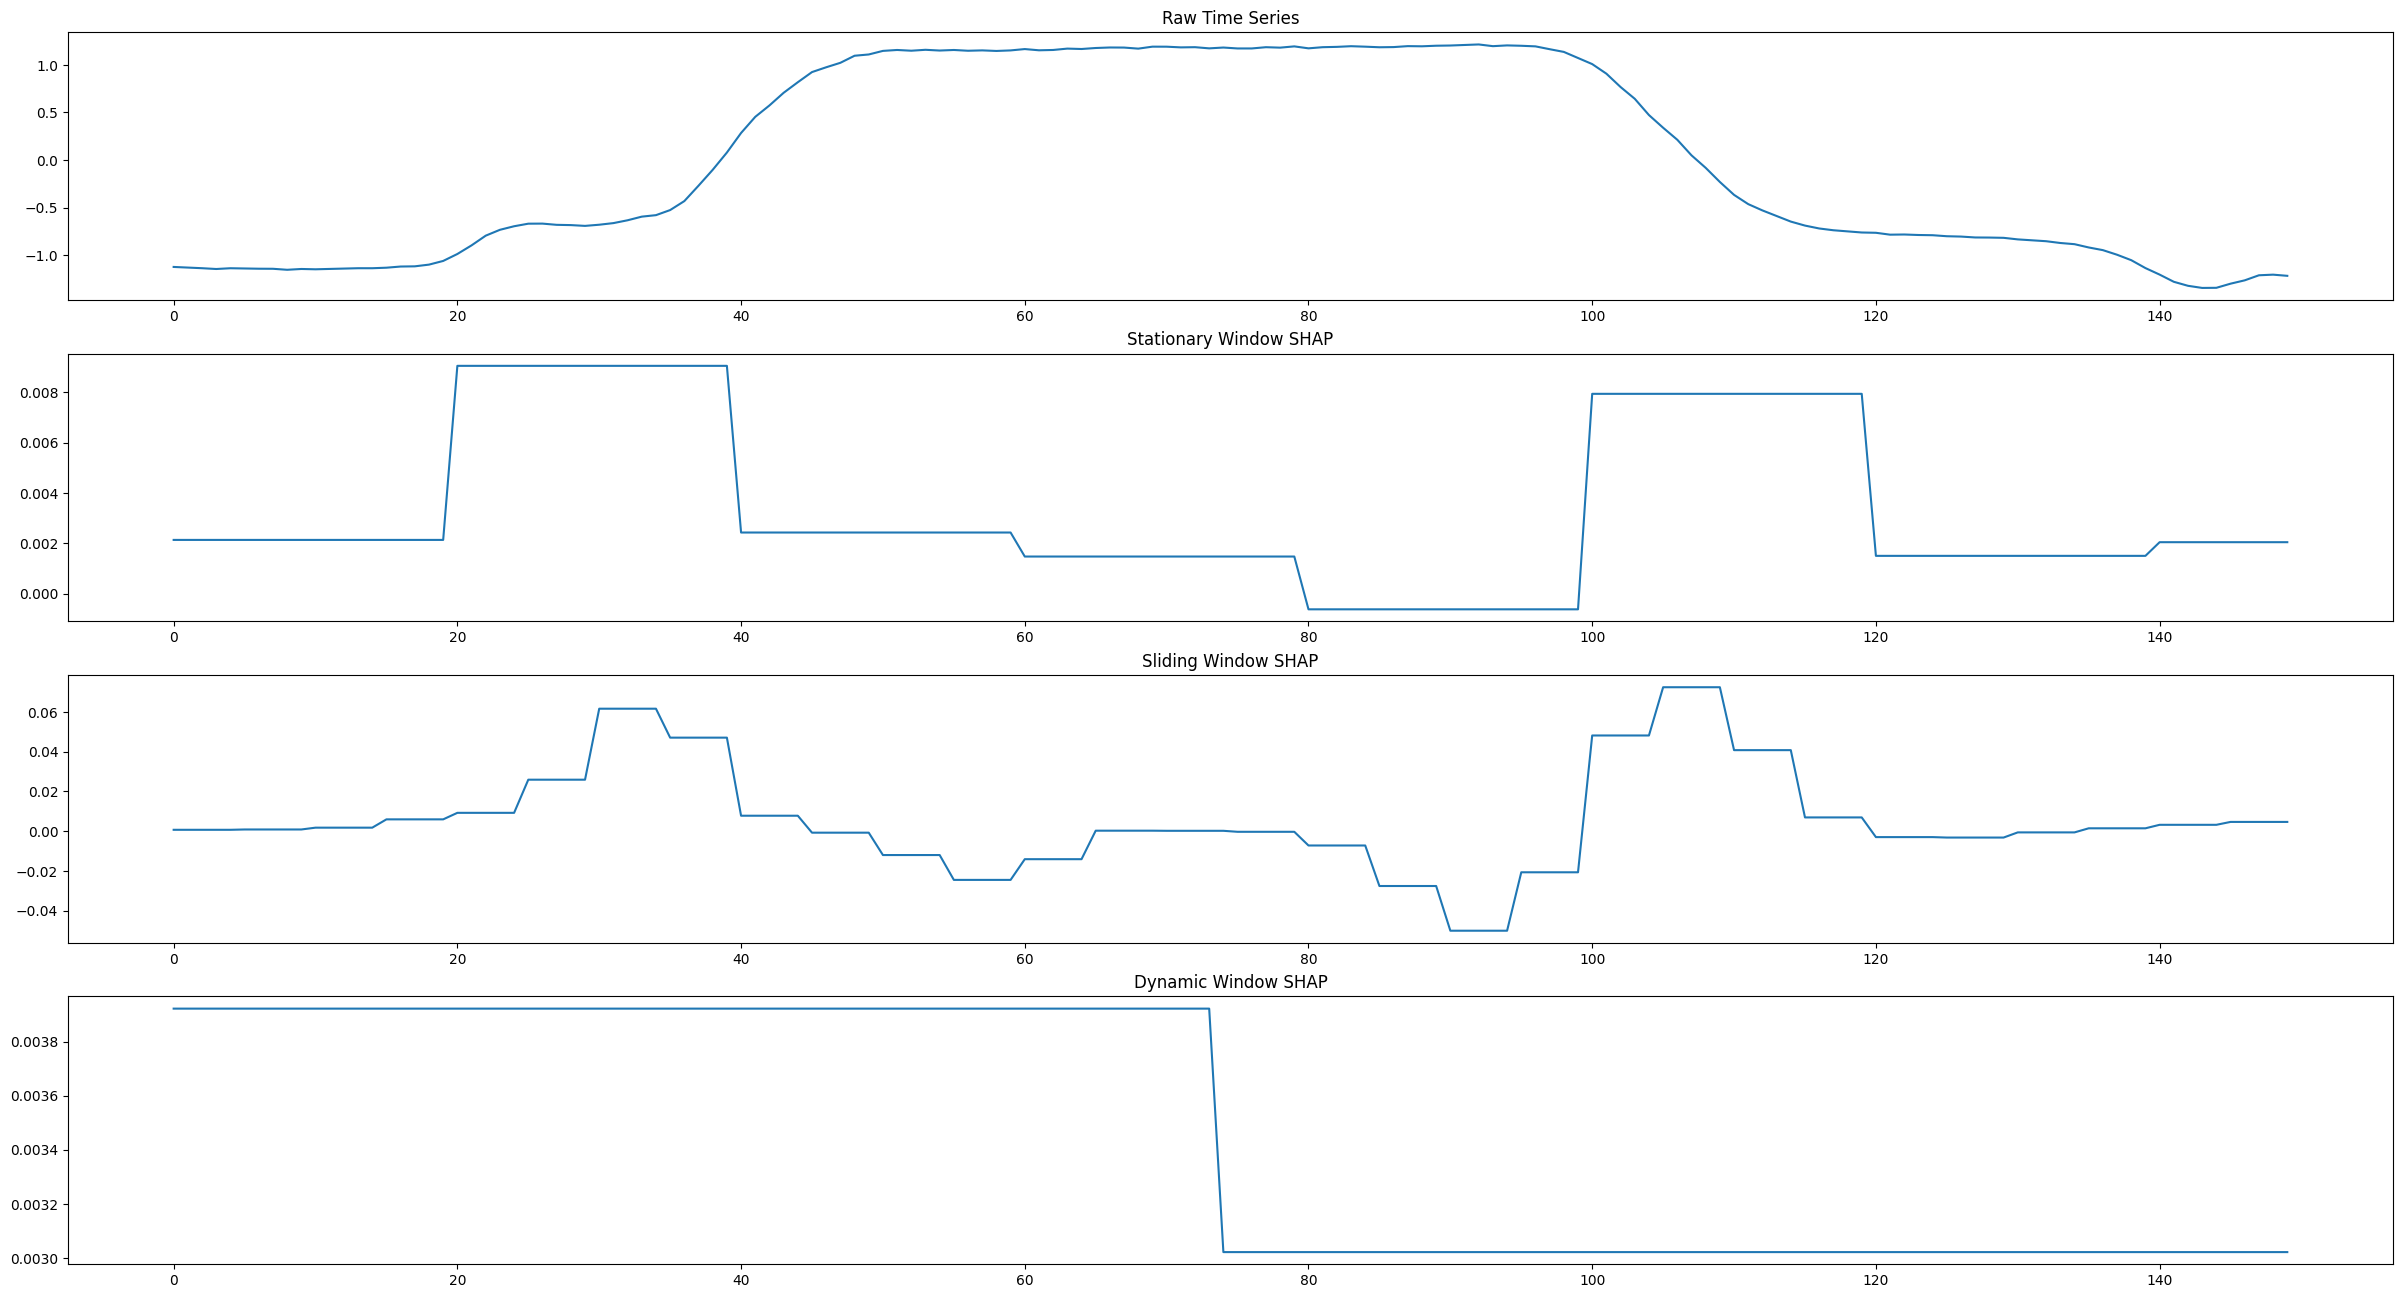

In [10]:
exps = [X_test[[0]], stationary_exp, sliding_exp, dynamic_exp]
titles = ['Raw Time Series', 'Stationary Window SHAP', 'Sliding Window SHAP', 'Dynamic Window SHAP']
plot_explanation(exps, titles)

In [11]:
ls_exp = explain_with_LIMESegment(X_test[0], clf)


In [12]:
leftist_exp = explain_with_LEFTIST(X_test[0], clf, X_train)

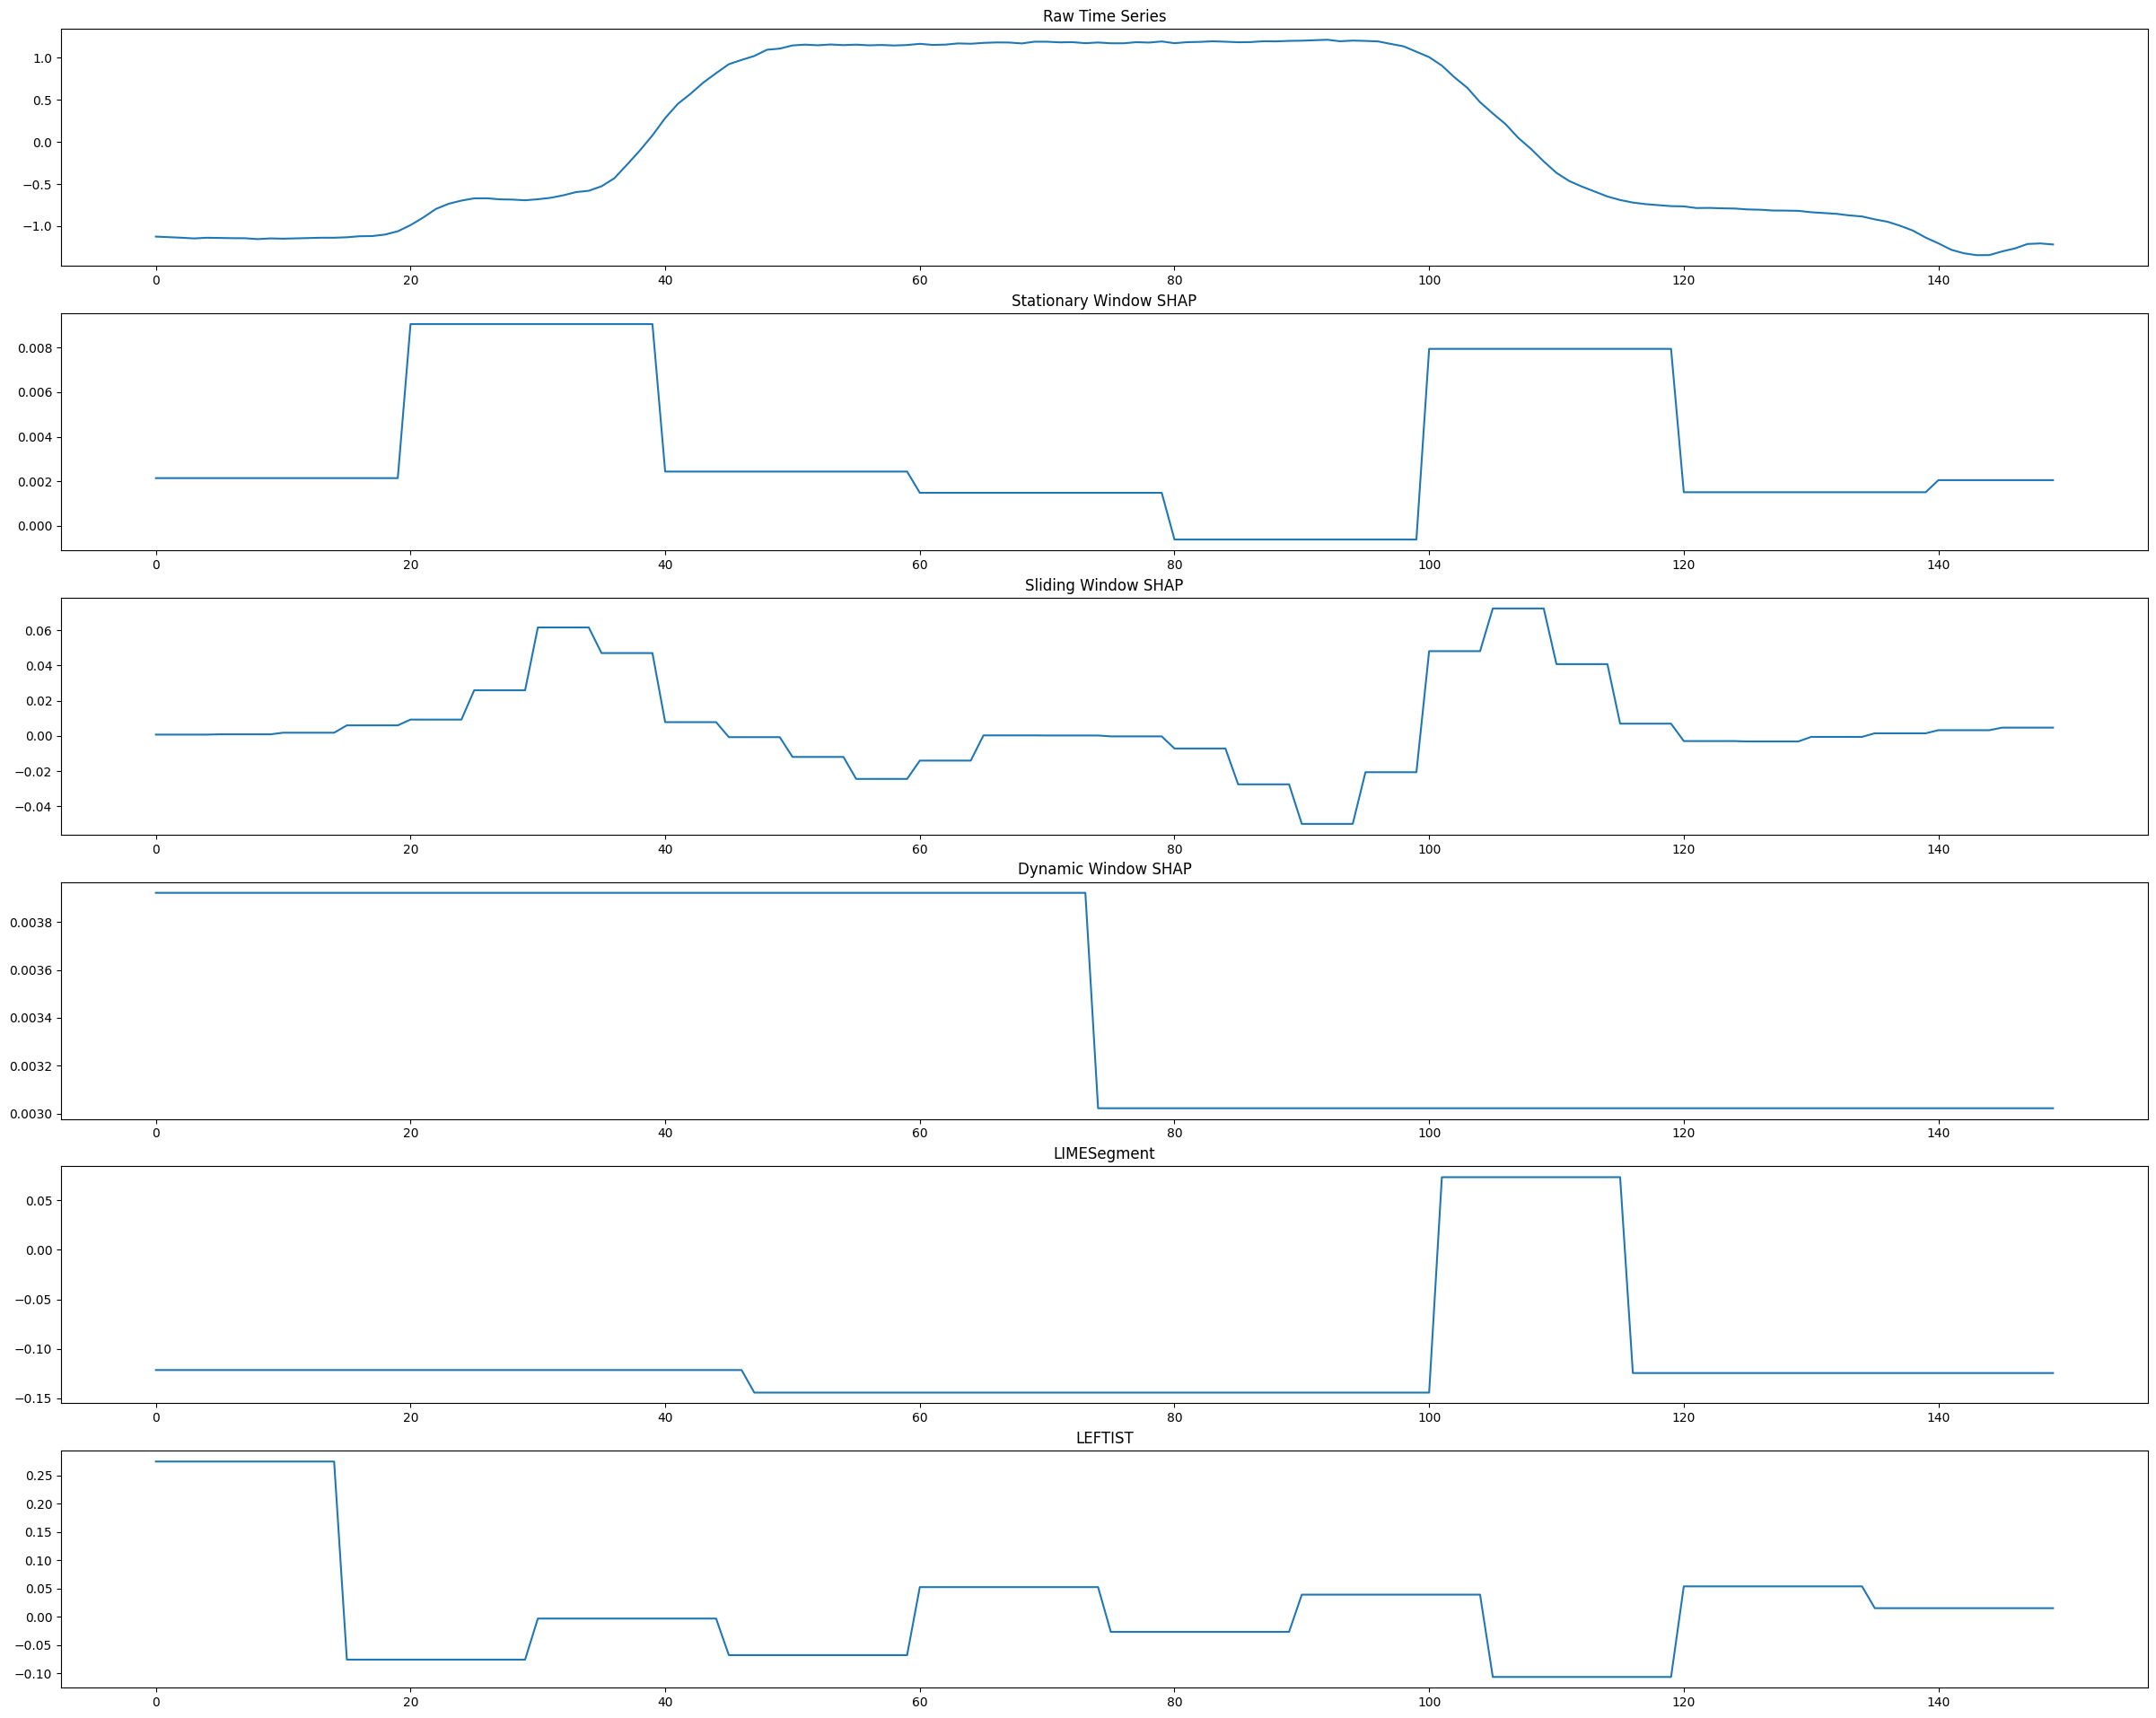

In [13]:
exps = [X_test[[0]], stationary_exp, sliding_exp, dynamic_exp, ls_exp, leftist_exp]
titles = ['Raw Time Series', 'Stationary Window SHAP', 'Sliding Window SHAP', 'Dynamic Window SHAP', 'LIMESegment', 'LEFTIST']
plot_explanation(exps, titles)